[ 1.          2.41421356 -0.41421356]
[[ 1.         -0.26120387  0.54691816]
 [ 0.          0.89180581 -0.32037724]
 [ 0.          0.36939806  0.77345908]]


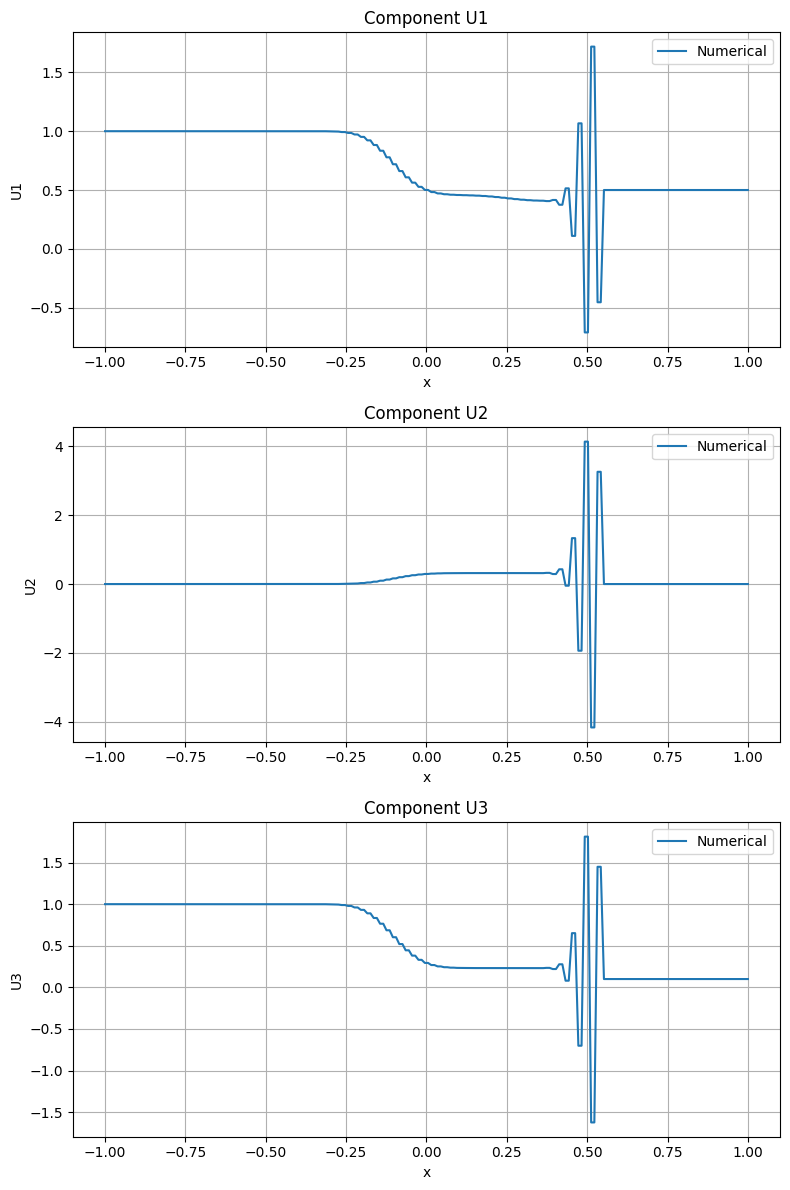

In [7]:
import numpy as np
import matplotlib.pyplot as plt


L = -1.0  
R = 1.0   
T = 0.25 
N = 200   
dx = (R - L) / N 
dt = 0.9 * dx / 2 

# Matrice A
A = np.array([[1, 0, -1],
              [0, 2, 1],
              [0, 1, 0]])

# Calcul des valeurs propres et vecteurs propres de A
eigenvalues, eigenvectors = np.linalg.eig(A)

print(eigenvalues)
print(eigenvectors)
# Grille spatiale et temps
x = np.linspace(L, R, N + 2)  # Inclure les cellules fantômes
nt = int(T / dt)  # Nombre de pas temporels

# Condition initiale (problème de Riemann)
U = np.zeros((N + 2, 3))  # Tableau pour la solution (3 composantes)
UL = np.array([1, 0, 1])  # État à gauche
UR = np.array([0.5, 0, 0.1])  # État à droite
U[x < 0, :] = UL
U[x >= 0, :] = UR

# Fonction pour calculer le flux f(U) = AU
def flux(U):
    return np.dot(A, U.T).T

# Schéma local de Lax-Friedrichs
def lax_friedrichs(U, dt, dx):
    U_new = np.zeros_like(U)
    for i in range(1, N + 1):
        U_new[i] = 0.5 * (U[i + 1] + U[i - 1]) - (dt / (2 * dx)) * (flux(U[i + 1]) - flux(U[i - 1]))
    # Conditions aux limites (interpolation constante)
    U_new[0] = U_new[1]
    U_new[-1] = U_new[-2]
    return U_new

# Résolution dans le temps
U_num = U.copy()
for _ in range(nt):
    U_num = lax_friedrichs(U_num, dt, dx)

# Calcul de la solution exacte
def exact_solution(x, t, UL, UR, eigenvalues, eigenvectors):
    # Projeter les états initiaux sur les vecteurs propres
    delta_U = UR - UL
    alpha = np.linalg.solve(eigenvectors, delta_U)  # Coefficients dans la base des vecteurs propres

    U_exact = np.zeros((len(x), 3))
    for i, xi in enumerate(x):
        U_exact[i] = UL
        for j, lambd in enumerate(eigenvalues):
            if xi - lambd * t >= 0:
                U_exact[i] += alpha[j] * eigenvectors[:, j]
    return U_exact

U_exact = exact_solution(x, T, UL, UR, eigenvalues, eigenvectors)

# Affichage des résultats
components = ['U1', 'U2', 'U3']
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

for i in range(3):
    #axes[i].plot(x, U_exact[:, i], label="Exact", linestyle="--")
    axes[i].plot(x, U_num[:, i], label="Numerical", linestyle="-")
    axes[i].set_title(f"Component {components[i]}")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel(components[i])
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


